### Imports

In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import os
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Part 1

In [2]:
# Loading AlexNet Model
model = models.alexnet(weights = models.AlexNet_Weights.DEFAULT).to(device)
model.eval()

# Loading Image Paths
image_folder = "./Image Set"
image_paths = [os.path.join(image_folder, file) for file in os.listdir(image_folder)]

# Defining Image Transformation
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Mapping Layers to Names
layer_map = {
    'Conv1': model.features[0],
    'Conv2': model.features[3],
    'Conv3': model.features[6],
    'Conv4': model.features[8],
    'Conv5': model.features[10],
    'fc6': model.classifier[1],
    'fc7': model.classifier[4],
}

# Function For Extracting Features From a Given Layer
def layer_output(layer, x):
    outputs = []

    def forward_hook(module, input, output):
        outputs.append(output)

    h = layer.register_forward_hook(forward_hook)
    model(x.unsqueeze(0).to(device))
    h.remove()
    return outputs[0]

# Extracting Features For Each Image
features = {layer: [] for layer in layer_map}

# Sort images numerically
image_paths = sorted(image_paths, key=lambda x: int(os.path.basename(x).split('.')[0]))

for image_path in image_paths:
    image = Image.open(image_path).convert('RGB')
    image = transform(image)

    for layer_name, layer in layer_map.items():
        output = layer_output(layer, image)
        features[layer_name].append(output.cpu().detach().numpy().ravel())

### Part 2

In [3]:
# RDM Creation Function
def create_rdm(features):
    return squareform(pdist(features, 'euclidean'))

# RDM For Each Layer
rdms = {layer: create_rdm(np.array(features[layer])) for layer in features}

### Part 3

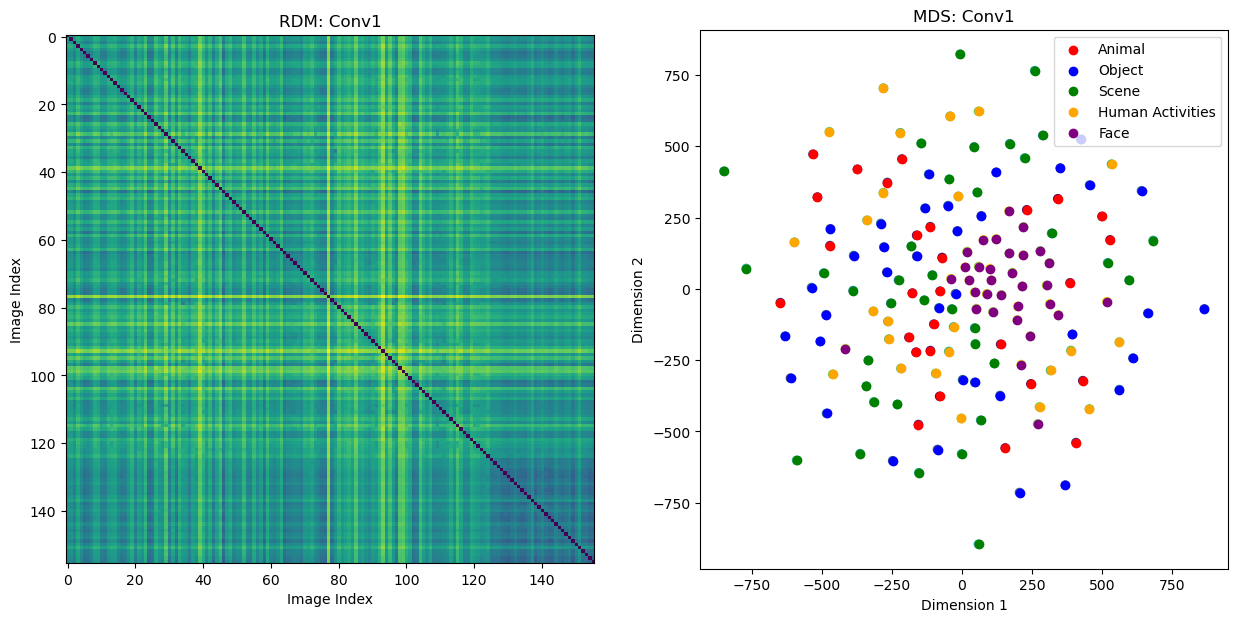

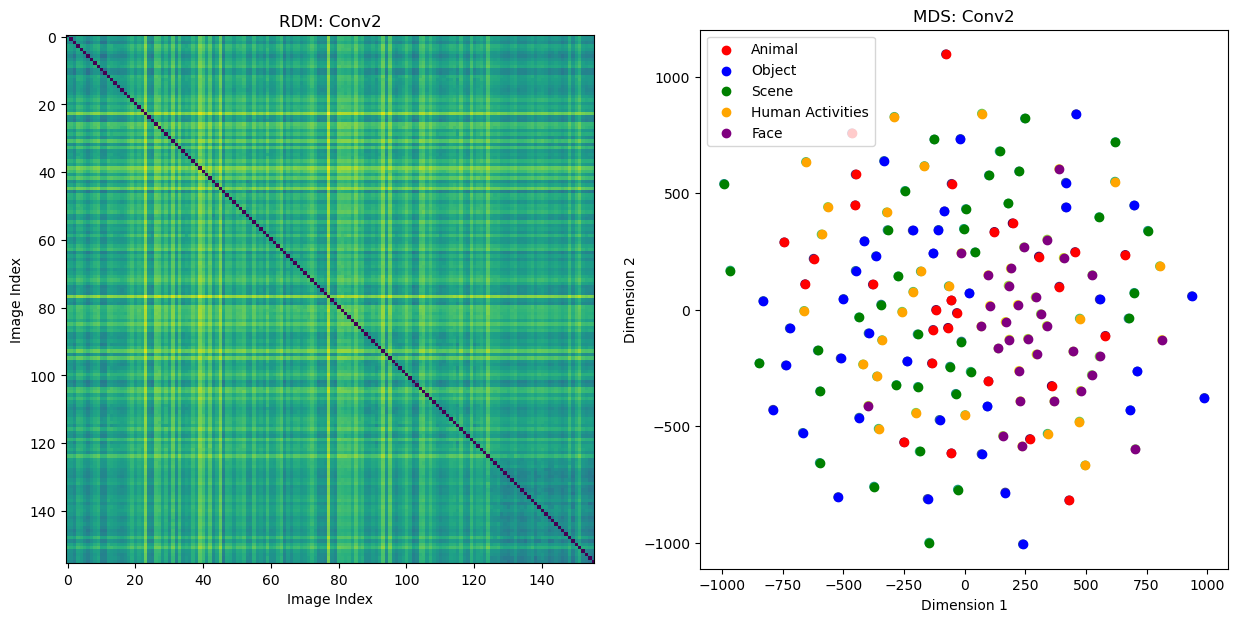

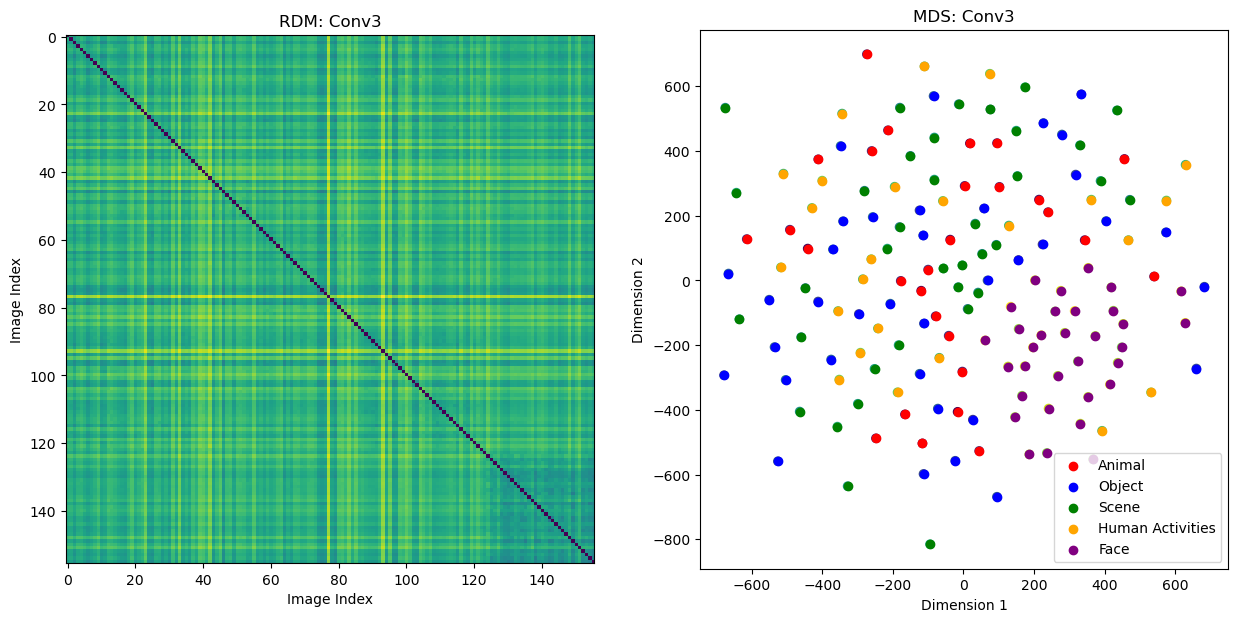

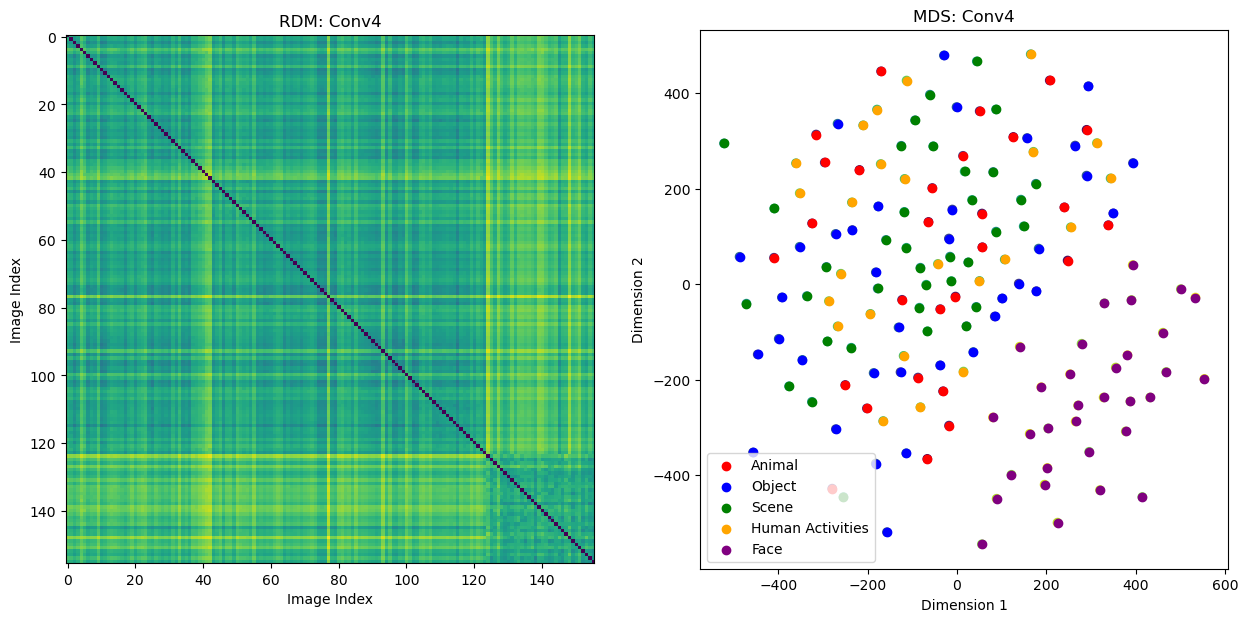

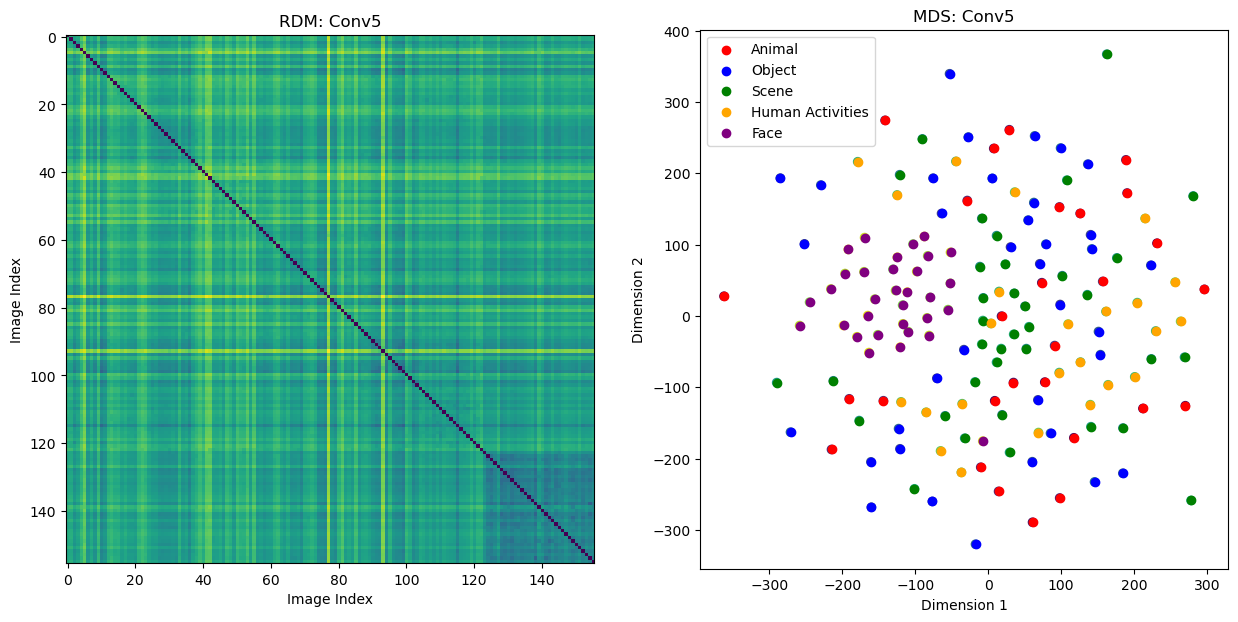

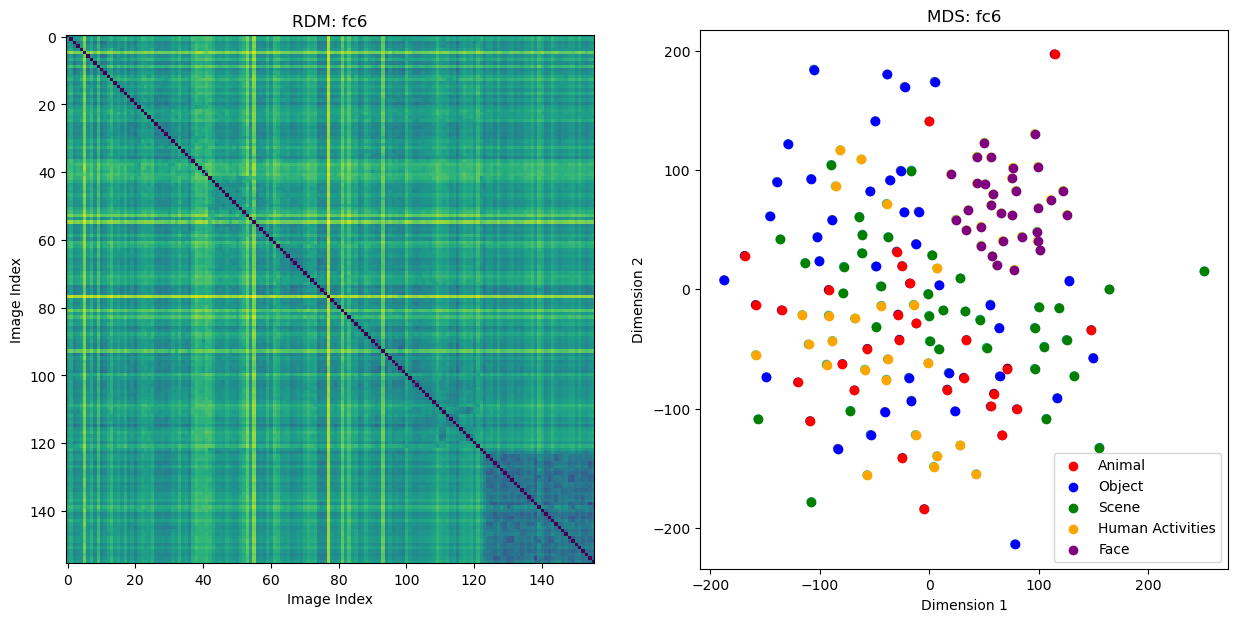

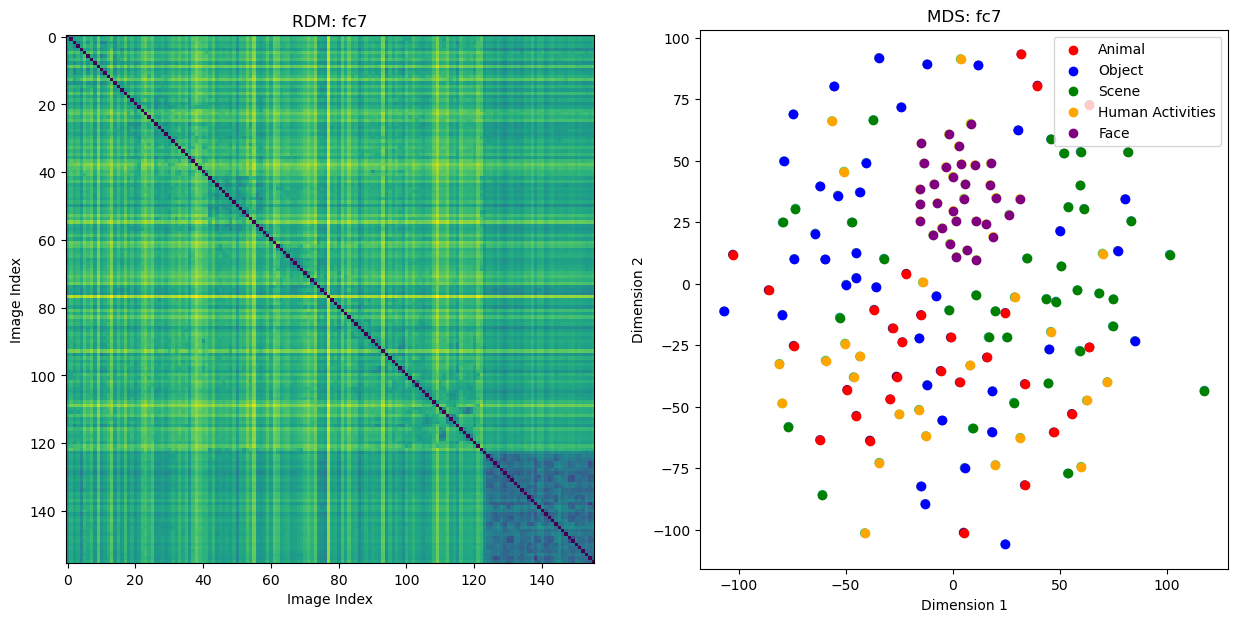

In [4]:
# MDS
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=10, normalized_stress='auto')
mds_results = {layer: mds.fit_transform(rdms[layer]) for layer in rdms}

# Plotting RDM and MDS Results
for layer in rdms:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

    # RDM
    ax1.imshow(rdms[layer])
    ax1.set_title(f"RDM: {layer}")
    ax1.set_xlabel('Image Index')
    ax1.set_ylabel('Image Index')

    # MDS
    ax2.scatter(mds_results[layer][:, 0], mds_results[layer][:, 1], c=np.arange(156))
    ax2.set_title(f"MDS: {layer}")
    ax2.set_xlabel('Dimension 1')
    ax2.set_ylabel('Dimension 2')

    # MDS Legend (image 1-28 = Animals, 29-64 = Objects, 65-100 = Scenes, 101-124 = Human Activities, 125-156 = Faces)
    animal_indices = range(0, 28)
    object_indices = range(28, 64)
    scene_indices = range(64, 100)
    activity_indices = range(100, 124)
    face_indices = range(124, 156)

    ax2.scatter(mds_results[layer][animal_indices, 0], mds_results[layer][animal_indices, 1], c='red', label='Animal')
    ax2.scatter(mds_results[layer][object_indices, 0], mds_results[layer][object_indices, 1], c='blue', label='Object')
    ax2.scatter(mds_results[layer][scene_indices, 0], mds_results[layer][scene_indices, 1], c='green', label='Scene')
    ax2.scatter(mds_results[layer][activity_indices, 0], mds_results[layer][activity_indices, 1], c='orange', label='Human Activities')
    ax2.scatter(mds_results[layer][face_indices, 0], mds_results[layer][face_indices, 1], c='purple', label='Face')

    # Legend for the 5 colours
    ax2.legend()

plt.show()
